# PyDS Individual Project — Basetable Construction
**Student:** Beatrice Infurna
**Course:** Python for Data Science  
**Purpose:** Build a basetable with IVs (1996) and DVs (1997) using the Czech Bank Dataset.


## **Step 1-Importing data**

In [3391]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)


## Data Loading

The raw banking tables are not fully included in this repository due to size considerations.
The code below documents the original data loading and preprocessing steps used to construct
the final basetable.

The processed basetable is available under `data/processed/`.


In [ ]:

# Path to raw data (not included in the repository due to size considerations)
data_path = "../data/raw/"



In [3393]:
account = pd.read_csv(data_path + "account.asc", sep=";", quotechar='"')
disp    = pd.read_csv(data_path + "disp.asc", sep=";", quotechar='"')
loan    = pd.read_csv(data_path + "loan.asc", sep=";", quotechar='"')
order   = pd.read_csv(data_path + "order.asc", sep=";", quotechar='"')
card    = pd.read_csv(data_path + "card.asc", sep=";", quotechar='"')
trans = pd.read_csv(data_path + "trans.asc", sep=";", quotechar='"', low_memory=False)
district= pd.read_csv(data_path + "district.asc", sep=";", quotechar='"')
client = pd.read_csv(data_path + "client.asc", sep=";", quotechar='"')


In [3394]:
account.columns = ["account_id", "district_id", "frequency", "date"]

disp.columns = ["disp_id", "client_id", "account_id", "type"]

client.columns = ["client_id", "birth_number", "district_id"]

loan.columns = ["loan_id", "account_id", "date", "amount", "duration", "payments", "status"]

order.columns = ["order_id", "account_id", "bank_to", "account_to", "amount", "k_symbol"]

card.columns = ["card_id", "disp_id", "type", "issued"]

trans.columns = ["trans_id", "account_id", "date", "type", "operation",
                 "amount", "balance", "k_symbol", "bank", "account"]
district.columns = [
    "district_id", "district_name", "region",
    "n_inhabitants",
    "n_municipalities_lt_499",
    "n_municipalities_500_1999",
    "n_municipalities_2000_9999",
    "n_municipalities_gt_10000",
    "n_cities",
    "urban_ratio",
    "avg_salary",
    "unemployment_rate_95",
    "unemployment_rate_96",
    "entrepreneurs_per_1000",
    "crimes_95",
    "crimes_96"]


## **Step 2: Converting data column+ Basic formatting**

In [3395]:
card["issued_clean"] = card["issued"].str.split().str[0]
card_date.info()


<class 'pandas.core.series.Series'>
RangeIndex: 892 entries, 0 to 891
Series name: issued
Non-Null Count  Dtype 
--------------  ----- 
892 non-null    object
dtypes: object(1)
memory usage: 7.1+ KB


In [3396]:
account["date"] = pd.to_datetime(account["date"], format="%y%m%d", errors="coerce")
loan["date"]    = pd.to_datetime(loan["date"], format="%y%m%d", errors="coerce")
card["issued_clean"] = pd.to_datetime(card["issued_clean"], format="%y%m%d", errors="coerce")
trans["date"]   = pd.to_datetime(trans["date"], format="%y%m%d", errors="coerce")

In [3397]:
client.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5369 entries, 0 to 5368
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   client_id     5369 non-null   int64
 1   birth_number  5369 non-null   int64
 2   district_id   5369 non-null   int64
dtypes: int64(3)
memory usage: 126.0 KB


In [3398]:
client.head()

,client_id,birth_number,district_id
0,1,706213,18
1,2,450204,1
2,3,406009,1
3,4,561201,5
4,5,605703,5


In [3399]:
#This next set of coding will give us the age of the customers from the birth_number column
client["birth_number"] = client["birth_number"].astype(int)


In [3400]:
client["year"] = client["birth_number"] // 10000
client["month"] = (client["birth_number"] % 10000) // 100
client["day"] = client["birth_number"] % 100



In [3401]:
client["gender"] = np.where(client["month"] > 50, "F", "M")
client["month"] = np.where(client["month"] > 50, client["month"] - 50, client["month"])


In [3402]:
client["year_full"] = 1900 + client["year"]


In [3403]:
client["birth_date"] = pd.to_datetime(
    dict(
        year=client["year_full"],
        month=client["month"],
        day=client["day"]),
    errors="coerce")




In [3404]:
client[["birth_number", "year_full", "month", "day", "gender", "birth_date"]].head()
client["birth_date"].isna().sum()

0

In [3405]:
cutoff = pd.to_datetime("1996-12-31")

client["age_1996"] = (cutoff - client["birth_date"]).dt.days // 365


In [3406]:
client.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5369 entries, 0 to 5368
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   client_id     5369 non-null   int64         
 1   birth_number  5369 non-null   int32         
 2   district_id   5369 non-null   int64         
 3   year          5369 non-null   int32         
 4   month         5369 non-null   int32         
 5   day           5369 non-null   int32         
 6   gender        5369 non-null   object        
 7   year_full     5369 non-null   int32         
 8   birth_date    5369 non-null   datetime64[ns]
 9   age_1996      5369 non-null   int64         
dtypes: datetime64[ns](1), int32(5), int64(3), object(1)
memory usage: 314.7+ KB


## **Step 3: Building the Base Relational Table**

In [3407]:
owners = disp[disp["type"] == "OWNER"].copy()
print(owners.shape)

(4500, 4)


In [3408]:
owners.head()
type(owners)

pandas.core.frame.DataFrame

In [3409]:
client_account = owners.merge(client, on="client_id", how="left")

In [3410]:
client_account.shape 

(4500, 13)

In [3411]:
client_account.head()

,disp_id,client_id,account_id,type,birth_number,district_id,year,month,day,gender,year_full,birth_date,age_1996
0,1,1,1,OWNER,706213,18,70,12,13,F,1970,1970-12-13,26
1,2,2,2,OWNER,450204,1,45,2,4,M,1945,1945-02-04,51
2,4,4,3,OWNER,561201,5,56,12,1,M,1956,1956-12-01,40
3,6,6,4,OWNER,190922,12,19,9,22,M,1919,1919-09-22,77
4,7,7,5,OWNER,290125,15,29,1,25,M,1929,1929-01-25,67


In [3412]:
client_account = client_account.merge(account, on="account_id", how="left")


In [3413]:
client_account = client_account.rename(columns={
    "district_id_x": "district_id"})

In [3414]:
client_account = client_account.rename(columns={
    "district_id_y": "branch_district_id"})

In [3415]:
client_account.columns


Index(['disp_id', 'client_id', 'account_id', 'type', 'birth_number', 'district_id', 'year', 'month', 'day', 'gender', 'year_full', 'birth_date', 'age_1996', 'branch_district_id', 'frequency', 'date'], dtype='object')

In [3416]:
client_account = client_account.merge(district, on="district_id", how="left")


## **Step 4: Timeline filtering**

In [3417]:
cutoff_creation = pd.to_datetime("1995-12-31")

client_account = client_account[client_account["date"] <= cutoff_creation].copy()

print(client_account.shape)


(2239, 31)


In [3418]:
#We keep only accounts with at least one transaction in 1996, to fulfill the requirement of clients having sufficient information in the time window
trans["year"] = trans["date"].dt.year
trans_1996 = trans[trans["year"] == 1996].copy()
active_accounts_1996 = trans_1996["account_id"].unique()
len(active_accounts_1996)


3602

In [3419]:
client_account = client_account[
    client_account["account_id"].isin(active_accounts_1996)].copy()

print(client_account.shape)


(2239, 31)


## **Step5: Feature Engineering (Independent Variable)-1996**

### Account table features


In [3420]:
#Account age at the end of 1996
cutoff_1996 = pd.to_datetime("1996-12-31")
client_account["account_age_days"] = (
    cutoff_1996 - client_account["date"]).dt.days


In [3421]:
client_account.columns


Index(['disp_id', 'client_id', 'account_id', 'type', 'birth_number', 'district_id', 'year', 'month', 'day', 'gender', 'year_full', 'birth_date', 'age_1996', 'branch_district_id', 'frequency', 'date', 'district_name', 'region', 'n_inhabitants', 'n_municipalities_lt_499', 'n_municipalities_500_1999', 'n_municipalities_2000_9999', 'n_municipalities_gt_10000', 'n_cities', 'urban_ratio', 'avg_salary', 'unemployment_rate_95', 'unemployment_rate_96', 'entrepreneurs_per_1000', 'crimes_95', 'crimes_96', 'account_age_days'], dtype='object')

In [3422]:
#frequency 
client_account = pd.get_dummies(
    client_account,
    columns=["frequency"],
    prefix="freq",
    drop_first=True)


In [3423]:
account_cols = ["account_age_days"] + [c for c in client_account.columns if c.startswith("freq_")]


In [3424]:
client_account_iv = (
    client_account.groupby("client_id")[account_cols].mean().reset_index())


In [3425]:
basetable = client[
    client["client_id"].isin(client_account["client_id"])
].copy()

print("Basetable initialized with:", basetable["client_id"].nunique(), "clients")

Basetable initialized with: 2239 clients


In [3426]:
basetable = basetable.merge(client_account_iv, on="client_id", how="left")


### Transaction-Based Features

In [3427]:
client_accounts = client_account[["client_id", "account_id"]].drop_duplicates()


In [3428]:
trans["year"] = trans["date"].dt.year
trans_1996 = trans[trans["year"] == 1996].copy()


In [3429]:
valid_accounts = client_accounts["account_id"].unique()
trans_1996 = trans_1996[trans_1996["account_id"].isin(valid_accounts)]


In [3430]:
#Transaction count
txn_count_acc = trans_1996.groupby("account_id")["trans_id"].count()\
    .rename("txn_count_1996")


In [3431]:
# Total Incoming amount
incoming_acc = trans_1996[trans_1996["type"] == "PRIJEM"]\
    .groupby("account_id")["amount"].sum().rename("incoming_total_1996")

#Total Outgoing amount
outgoing_acc = trans_1996[trans_1996["type"] == "VYDAJ"]\
    .groupby("account_id")["amount"].sum().rename("outgoing_total_1996")

In [3432]:
# Transaction amount statistics
txn_stats_acc = trans_1996.groupby("account_id")["amount"].agg(
    avg_txn_1996 = "mean",
    max_txn_1996 = "max",
    min_txn_1996 = "min")

In [3433]:
client_account = client_account.merge(txn_count_acc, on="account_id", how="left")
client_account = client_account.merge(incoming_acc, on="account_id", how="left")
client_account = client_account.merge(outgoing_acc, on="account_id", how="left")
client_account = client_account.merge(txn_stats_acc, on="account_id", how="left")
#but this is still account-level, we need client-level

In [3434]:
account_iv_cols = [
    "txn_count_1996",
    "incoming_total_1996",
    "outgoing_total_1996",
    "avg_txn_1996",
    "max_txn_1996",
    "min_txn_1996"]

client_iv = client_account.groupby("client_id")[account_iv_cols].agg({
    "txn_count_1996": "sum",
    "incoming_total_1996": "sum",
    "outgoing_total_1996": "sum",
    "avg_txn_1996": "mean",
    "max_txn_1996": "max",
    "min_txn_1996": "min"}).reset_index()


In [3435]:
basetable = client.merge(client_iv, on="client_id", how="left")


### K-symbol features

In [3436]:

trans["year"] = trans["date"].dt.year
trans_1996 = trans[(trans["year"] == 1996) & (trans["account_id"].isin(client_account["account_id"]))]


In [3437]:
#K-symbol counts per account
k_symbols = ["POJISTNE", "SIPO", "SLUZBY", "UROK", "SANKC. UROK", "DUCHOD", "UVER"]

k_symbol_features = {}

for ks in k_symbols:
    k_symbol_features[f"k_{ks.lower().replace('.', '').replace(' ', '_')}_count_1996"] = \
        trans_1996[trans_1996["k_symbol"] == ks] \
        .groupby("account_id")["trans_id"].count()


In [3438]:
for colname, series in k_symbol_features.items():
    client_account = client_account.merge(series.rename(colname), on="account_id", how="left")


In [3439]:
k_cols = [col for col in client_account.columns if col.endswith("_count_1996")]

client_k_iv = client_account.groupby("client_id")[k_cols].sum().reset_index()


In [3440]:
basetable = basetable.merge(client_k_iv, on="client_id", how="left")


### Operation-type features

In [3441]:
trans["year"] = trans["date"].dt.year

trans_1996 = trans[
    (trans["year"] == 1996) &
    (trans["account_id"].isin(client_account["account_id"]))
].copy()


In [3442]:
operation_types = [
    "VYBER KARTOU",  
    "VKLAD",           
    "PREVOD Z UCTU",  
    "VYBER",          
    "PREVOD NA UCET" ]


In [3443]:
#Operation type counts per account
operation_features = {}

for op in operation_types:
    clean_name = op.lower().replace(" ", "_")
    colname = f"op_{clean_name}_count_1996"
    
    operation_features[colname] = (
        trans_1996[trans_1996["operation"] == op]
        .groupby("account_id")["trans_id"]
        .count() )


In [3444]:
for colname, series in operation_features.items():
    client_account = client_account.merge(
        series.rename(colname),
        on="account_id",
        how="left" )


In [3445]:
op_cols = [col for col in client_account.columns if col.startswith("op_")]

client_op_iv = (
    client_account
    .groupby("client_id")[op_cols]
    .sum()
    .reset_index())


In [3446]:
basetable = basetable.merge(client_op_iv, on="client_id", how="left")


### Balance-based features

In [3447]:
trans["year"] = trans["date"].dt.year

trans_1996 = trans[
    (trans["year"] == 1996) &
    (trans["account_id"].isin(client_account["account_id"]))
].copy()


In [3448]:
#Balance stats per per account ( we will later convert to client-level
balance_stats_acc = trans_1996.groupby("account_id")["balance"].agg(
    avg_balance_1996 = "mean",
    max_balance_1996 = "max",
    min_balance_1996 = "min",
    std_balance_1996 = "std")


In [3449]:
client_account = client_account.merge(
    balance_stats_acc, on="account_id", how="left")


In [3450]:
balance_cols = [
    "avg_balance_1996",
    "max_balance_1996",
    "min_balance_1996",
    "std_balance_1996"]

client_balance_iv = (
    client_account
    .groupby("client_id")[balance_cols]
    .agg({
        "avg_balance_1996": "mean",
        "max_balance_1996": "max",
        "min_balance_1996": "min",
        "std_balance_1996": "mean"})
    .reset_index())


In [3451]:
basetable = basetable.merge(client_balance_iv, on="client_id", how="left")


### RFM features

In [3452]:
trans["year"] = trans["date"].dt.year

trans_1996 = trans[
    (trans["year"] == 1996) &
    (trans["account_id"].isin(client_account["account_id"]))
].copy()


In [3453]:
#Last transaction date per account
last_txn_date_acc = trans_1996.groupby("account_id")["date"].max().rename("last_txn_1996")


In [3454]:
#Recency per account
cutoff_1996 = pd.to_datetime("1996-12-31")

recency_acc = (cutoff_1996 - last_txn_date_acc).dt.days.rename("recency_1996")


In [3455]:
client_account = client_account.merge(recency_acc, on="account_id", how="left")


In [3456]:
#recency to client level
client_recency_iv = (
    client_account.groupby("client_id")["recency_1996"].min().reset_index())


In [3457]:
basetable = basetable.merge(client_recency_iv, on="client_id", how="left")


###  Permanent order features

In [3458]:
order_1996 = order[
    order["account_id"].isin(client_account["account_id"])].copy()


In [3459]:
#Total number of permanent orders per account
order_count_acc = order_1996.groupby("account_id")["order_id"].count().rename("order_count")


In [3460]:
#Total amount of permanent orders per account
order_amount_acc = order_1996.groupby("account_id")["amount"].sum().rename("order_amount_total")


In [3461]:
#K-simbols counts per account
po_k_symbols = ["POJISTNE", "SIPO", "LEASING", "UVER"]

po_features = {}

for ks in po_k_symbols:
    clean_name = ks.lower()
    colname = f"po_{clean_name}_count"

    po_features[colname] = (
        order_1996[order_1996["k_symbol"] == ks]
        .groupby("account_id")["order_id"]
        .count())


In [3462]:
client_account = client_account.merge(order_count_acc, on="account_id", how="left")
client_account = client_account.merge(order_amount_acc, on="account_id", how="left")

for col, s in po_features.items():
    client_account = client_account.merge(s.rename(col), on="account_id", how="left")


In [3463]:
po_cols = ["order_count", "order_amount_total"] + list(po_features.keys())

client_po_iv = client_account.groupby("client_id")[po_cols].sum().reset_index()

In [3464]:
basetable = basetable.merge(client_po_iv, on="client_id", how="left")


###  Previous loan/card history before 1997

In [3465]:
loan["year"] = loan["date"].dt.year

loan_pre_1997 = loan[
    (loan["year"] < 1997) &
    (loan["account_id"].isin(client_account["account_id"]))].copy()


In [3466]:
#binary: do they have previous loan before 1997
prev_loan_flag = (
    loan_pre_1997
    .groupby("account_id")["loan_id"]
    .count()
    .rename("has_previous_loan"))
prev_loan_flag = (prev_loan_flag > 0).astype(int)


In [3467]:
#binary: loans granted in 1996
loan_1996 = loan[(loan["year"] == 1996)].copy()

loan_1996 = loan_1996.merge(
    disp[disp["type"] == "OWNER"][["disp_id", "client_id", "account_id"]],
    on="account_id",
    how="left")

loan_1996_flag = (
    loan_1996.groupby("client_id")["loan_id"]
    .count()
    .rename("loan_1996"))

loan_1996_flag = (loan_1996_flag > 0).astype(int).reset_index()



In [3468]:
#Total previous loan amount per account
prev_loan_amt = (
    loan_pre_1997
    .groupby("account_id")["amount"]
    .sum()
    .rename("previous_loan_amount_total"))

In [3469]:
#Loan status indicator
prev_loan_problem = (
    loan_pre_1997[loan_pre_1997["status"].isin(["B", "D"])]
    .groupby("account_id")["loan_id"]
    .count()
    .rename("previous_loan_problem"))

prev_loan_problem = (prev_loan_problem > 0).astype(int)

In [3470]:
client_account = client_account.merge(prev_loan_flag, on="account_id", how="left")
client_account = client_account.merge(prev_loan_amt, on="account_id", how="left")
client_account = client_account.merge(prev_loan_problem, on="account_id", how="left")
client_account = client_account.merge(loan_1996_flag, on="client_id", how="left")

### Card features 

In [3471]:

card["year"] = card["issued_clean"].dt.year

card_pre_1997 = card[
    (card["year"] < 1997) &
    (card["disp_id"].isin(disp["disp_id"]))].copy()



In [3472]:
card_pre_1997 = card_pre_1997.merge(
    disp[["disp_id", "account_id"]],
    on="disp_id",
    how="left")


In [3473]:
#binary: have card before 1997
card_flag = (
    card_pre_1997.groupby("account_id")["card_id"].count().rename("has_card_pre_1997"))

card_flag = (card_flag > 0).astype(int)


In [3474]:
#number of cards before 1997
card_count = (card_pre_1997.groupby("account_id")["card_id"].count().rename("card_count_pre_1997"))


In [3475]:
#cards issued in 1996
card_1996 = card[card["year"] == 1996].copy()

# Link to clients (owners only)
card_1996 = card_1996.merge(
    disp[disp["type"] == "OWNER"][["disp_id", "client_id", "account_id"]],
    on="disp_id",
    how="left")

# Flag: did the client get a card in 1996?
card_issued_1996 = (
    card_1996.groupby("client_id")["card_id"]
    .count()
    .rename("card_issued_1996"))

card_issued_1996 = (card_issued_1996 > 0).astype(int).reset_index()


In [3476]:
client_account = client_account.merge(card_flag, on="account_id", how="left")
client_account = client_account.merge(card_count, on="account_id", how="left")
client_account = client_account.merge(card_issued_1996, on="client_id", how="left")



In [3477]:
loan_card_cols = [
    "has_previous_loan",
    "previous_loan_amount_total",
    "previous_loan_problem",
    "loan_1996",
    "has_card_pre_1997",
    "card_count_pre_1997",
    "card_issued_1996"]

client_loan_card_iv = (
    client_account.groupby("client_id")[loan_card_cols]
    .max().reset_index())


### Extra features

In [3478]:
#kdiv
kdiv = (
    trans_1996.groupby("account_id")["k_symbol"]
    .nunique()
    .rename("k_symbol_diversity_1996"))

client_account = client_account.merge(kdiv, on="account_id", how="left")

kdiv_iv = (
    client_account.groupby("client_id")["k_symbol_diversity_1996"]
    .mean()
    .reset_index())

In [3479]:
#Ending balance
ending_balance = (
    trans_1996.sort_values("date")
    .groupby("account_id")["balance"]
    .last()
    .rename("ending_balance_1996"))

client_account = client_account.merge(ending_balance, on="account_id", how="left")

client_ending_balance_iv = (
    client_account.groupby("client_id")["ending_balance_1996"]
    .mean()
    .reset_index())


In [3480]:
#Number of accounts per client

n_accounts = (
    client_account.groupby("client_id")["account_id"]
    .nunique()
    .rename("n_accounts")
    .reset_index())


In [3481]:
#Operation type diversity 
op_types_acc = (
    trans_1996.groupby("account_id")["operation"]
    .nunique()
    .rename("op_type_diversity_1996"))

client_account = client_account.merge(op_types_acc, on="account_id", how="left")

diversity_iv = (
    client_account.groupby("client_id")["op_type_diversity_1996"]
    .mean()
    .reset_index())

basetable = basetable.merge(diversity_iv, on="client_id", how="left")

In [3482]:
basetable = client[
    client["client_id"].isin(client_account["client_id"])].copy()


In [3483]:
merge_blocks = [
    client_account_iv,
    client_iv,
    client_k_iv,
    client_op_iv,
    client_balance_iv,
    client_recency_iv,
    client_po_iv,
    client_loan_card_iv,
    client_ending_balance_iv,
    diversity_iv,
    kdiv_iv,
    n_accounts
]

for df in merge_blocks:
    basetable = basetable.merge(df, on="client_id", how="left")

In [3484]:
basetable = basetable.merge(client_loan_card_iv, on="client_id", how="left")


In [3485]:
#ratio features
basetable[["txn_count_1996_x", "txn_count_1996_y"]].describe()


,txn_count_1996_x,txn_count_1996_y
count,2239.000000,2239.000000
mean,73.171505,73.171505
std,17.699459,17.699459
min,5.000000,5.000000
25%,63.000000,63.000000
50%,72.000000,72.000000
75%,83.000000,83.000000
max,142.000000,142.000000


In [3486]:
[col for col in basetable.columns if "txn_count" in col]


['txn_count_1996_x', 'txn_count_1996_y']

In [3487]:
basetable = basetable.rename(columns={"txn_count_1996_x": "txn_count_1996"})


In [3488]:
basetable = basetable.drop(columns=["txn_count_1996_y"])


In [3489]:
basetable["incoming_total_1996"] = basetable["incoming_total_1996"].fillna(0)
basetable["outgoing_total_1996"] = basetable["outgoing_total_1996"].fillna(0)
basetable["txn_count_1996"] = basetable["txn_count_1996"].fillna(0)

basetable["ratio_credit_to_debit_1996"] = (
    basetable["incoming_total_1996"] /
    basetable["outgoing_total_1996"].replace(0, np.nan))

basetable["ratio_incoming_total_1996"] = (
    basetable["incoming_total_1996"] /
    (basetable["incoming_total_1996"] + basetable["outgoing_total_1996"]))

basetable["ratio_outgoing_total_1996"] = (
    basetable["outgoing_total_1996"] /
    (basetable["incoming_total_1996"] + basetable["outgoing_total_1996"]))

basetable["avg_txn_norm_1996"] = (
    basetable["avg_txn_1996"] /
    basetable["txn_count_1996"].replace(0, np.nan))

In [3490]:
#Permanent order diversity
po_cols = ["po_pojistne_count", "po_sipo_count", "po_leasing_count", "po_uver_count"]

basetable["po_type_diversity_1996"] = (
    (basetable[po_cols] > 0).sum(axis=1))


In [3491]:
len(basetable.columns) - 1   # subtract client_id


64

## **Step 6: Feature Engineering (Dependent variables)-1997**

### Dependent Variable: Loan Granted in 1997

In [3492]:
loan["year"] = loan["date"].dt.year

loan_1997 = loan[
    (loan["year"] == 1997)].copy()

loan_1997 = loan_1997.merge(
    disp[disp["type"] == "OWNER"][["disp_id", "client_id", "account_id"]],
    on="account_id",
    how="left")

dv_loan_1997 = (
    loan_1997.groupby("client_id")["loan_id"]
    .count()
    .rename("dv_loan_1997"))

dv_loan_1997 = (dv_loan_1997 > 0).astype(int).reset_index()

basetable = basetable.merge(dv_loan_1997, on="client_id", how="left")
basetable["dv_loan_1997"] = basetable["dv_loan_1997"].fillna(0).astype(int)


### Dependent Variable: Card issued in 1997 

In [3493]:
card["year"] = card["issued_clean"].dt.year

card_1997 = card[
    (card["year"] == 1997)].copy()

card_1997 = card_1997.merge(
    disp[disp["type"] == "OWNER"][["disp_id", "client_id", "account_id"]],
    on="disp_id",
    how="left")

dv_card_1997 = (
    card_1997.groupby("client_id")["card_id"]
    .count()
    .rename("dv_card_1997"))

dv_card_1997 = (dv_card_1997 > 0).astype(int).reset_index()

basetable = basetable.merge(dv_card_1997, on="client_id", how="left")
basetable["dv_card_1997"] = basetable["dv_card_1997"].fillna(0).astype(int)


In [3494]:
#Now we run the basetable
basetable.head(), basetable.shape


(   client_id  birth_number  district_id  year  month  day gender  year_full birth_date  age_1996  account_age_days  freq_POPLATEK PO OBRATU  freq_POPLATEK TYDNE  txn_count_1996  incoming_total_1996  outgoing_total_1996  avg_txn_1996  max_txn_1996  min_txn_1996  k_pojistne_count_1996  k_sipo_count_1996  k_sluzby_count_1996  k_urok_count_1996  k_sankc_urok_count_1996  k_duchod_count_1996  k_uver_count_1996  op_vyber_kartou_count_1996  op_vklad_count_1996  op_prevod_z_uctu_count_1996  op_vyber_count_1996  op_prevod_na_ucet_count_1996  avg_balance_1996  max_balance_1996  min_balance_1996  std_balance_1996  recency_1996  order_count  order_amount_total  po_pojistne_count  po_sipo_count  po_leasing_count  po_uver_count  has_previous_loan_x  previous_loan_amount_total_x  previous_loan_problem_x  loan_1996_x  has_card_pre_1997_x  card_count_pre_1997_x  card_issued_1996_x  ending_balance_1996  op_type_diversity_1996  k_symbol_diversity_1996  n_accounts  has_previous_loan_y  \
 0          1    

## **Step 7: Cleaning and export**

In [3495]:
#Missing values
basetable = basetable.fillna(0)


In [3496]:
basetable.columns


Index(['client_id', 'birth_number', 'district_id', 'year', 'month', 'day', 'gender', 'year_full', 'birth_date', 'age_1996', 'account_age_days', 'freq_POPLATEK PO OBRATU', 'freq_POPLATEK TYDNE', 'txn_count_1996', 'incoming_total_1996', 'outgoing_total_1996', 'avg_txn_1996', 'max_txn_1996', 'min_txn_1996', 'k_pojistne_count_1996', 'k_sipo_count_1996', 'k_sluzby_count_1996', 'k_urok_count_1996', 'k_sankc_urok_count_1996', 'k_duchod_count_1996', 'k_uver_count_1996', 'op_vyber_kartou_count_1996', 'op_vklad_count_1996', 'op_prevod_z_uctu_count_1996', 'op_vyber_count_1996', 'op_prevod_na_ucet_count_1996', 'avg_balance_1996', 'max_balance_1996', 'min_balance_1996', 'std_balance_1996', 'recency_1996', 'order_count', 'order_amount_total', 'po_pojistne_count', 'po_sipo_count', 'po_leasing_count', 'po_uver_count', 'has_previous_loan_x', 'previous_loan_amount_total_x', 'previous_loan_problem_x', 'loan_1996_x', 'has_card_pre_1997_x', 'card_count_pre_1997_x', 'card_issued_1996_x',
       'ending_bala

In [3497]:
#remove duplicates
cols_to_drop = [
    'has_previous_loan_y',
    'previous_loan_amount_total_y',
    'previous_loan_problem_y',
    'has_card_pre_1997_y',
    'loan_1996_y',
    'card_count_pre_1997_y',
    'op_type_diversity_1996_y',
    'card_issued_1996_y']

basetable = basetable.drop(columns=[c for c in cols_to_drop if c in basetable.columns])

In [3498]:
#rename "_x" columns
rename_map = {
    'has_previous_loan_x': 'has_previous_loan',
    'previous_loan_amount_total_x': 'previous_loan_amount_total',
    'previous_loan_problem_x': 'previous_loan_problem',
    'has_card_pre_1997_x': 'has_card_pre_1997',
    'loan_1996_x':'loan_granted_1996',
    'card_count_pre_1997_x': 'card_count_pre_1997',
    'op_type_diversity_1996_x': 'op_type_diversity_1996',
    'card_issued_1996_x': 'card_issued_1996'}

basetable = basetable.rename(columns=rename_map)

In [3499]:
# We make sure all variables are numeric 
basetable['gender'] = basetable['gender'].replace({'F': 1, 'M': 2}).astype(int)
basetable = basetable.apply(pd.to_numeric)

C:\Users\Source\AppData\Local\Temp\ipykernel_12956\2479272580.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  basetable['gender'] = basetable['gender'].replace({'F': 1, 'M': 2}).astype(int)


In [3500]:
print("Final basetable shape:", basetable.shape)

Final basetable shape: (2239, 60)


In [3501]:
cols_to_remove = [
    'birth_number', 
    'year', 'month', 'day',
    'year_full',
    'birth_date',
    'district_id',
    'issued']

basetable = basetable.drop(columns=[c for c in cols_to_remove if c in basetable.columns])



In [3502]:
print("Columns:", len(basetable.columns))

Columns: 53


In [3503]:
print("Final basetable shape:", basetable.shape)

Final basetable shape: (2239, 53)


In [3504]:
basetable.head()

,client_id,gender,age_1996,account_age_days,freq_POPLATEK PO OBRATU,freq_POPLATEK TYDNE,txn_count_1996,incoming_total_1996,outgoing_total_1996,avg_txn_1996,max_txn_1996,min_txn_1996,k_pojistne_count_1996,k_sipo_count_1996,k_sluzby_count_1996,k_urok_count_1996,k_sankc_urok_count_1996,k_duchod_count_1996,k_uver_count_1996,op_vyber_kartou_count_1996,op_vklad_count_1996,op_prevod_z_uctu_count_1996,op_vyber_count_1996,op_prevod_na_ucet_count_1996,avg_balance_1996,max_balance_1996,min_balance_1996,std_balance_1996,recency_1996,order_count,order_amount_total,po_pojistne_count,po_sipo_count,po_leasing_count,po_uver_count,has_previous_loan,previous_loan_amount_total,previous_loan_problem,loan_granted_1996,has_card_pre_1997,card_count_pre_1997,card_issued_1996,ending_balance_1996,op_type_diversity_1996,k_symbol_diversity_1996,n_accounts,ratio_credit_to_debit_1996,ratio_incoming_total_1996,ratio_outgoing_total_1996,avg_txn_norm_1996,po_type_diversity_1996,dv_loan_1997,dv_card_1997
0,1,1,26,648.0,0.0,0.0,74,50066.0,55579.2,1427.637838,3700.0,14.6,0.0,12.0,12.0,12.0,0.0,0.0,0.0,0.0,5.0,12.0,33,12.0,15980.927027,20525.5,11127.5,2172.106062,0,1.0,2452.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12674.5,4.0,3.0,1,0.900805,0.473907,0.526093,19.292403,1,0,0
1,2,2,51,1404.0,0.0,0.0,85,288542.9,202067.2,6624.907059,30354.0,14.6,0.0,12.0,12.0,12.0,0.0,0.0,0.0,0.0,5.0,12.0,44,12.0,36604.402353,61002.0,14025.8,11764.815403,0,2.0,10638.7,0.0,1.0,0.0,1.0,1.0,80952.0,0.0,0.0,0.0,0.0,0.0,53405.5,4.0,3.0,1,1.427955,0.588131,0.411869,77.940083,2,0,0
2,8,1,58,826.0,0.0,0.0,63,81507.7,81803.2,2592.236508,11600.0,14.6,0.0,12.0,12.0,12.0,0.0,12.0,0.0,0.0,0.0,12.0,27,12.0,30651.373016,39833.7,20377.3,4377.651064,0,1.0,3954.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33523.8,3.0,4.0,1,0.996388,0.499095,0.500905,41.146611,1,0,0
3,10,2,53,467.0,0.0,0.0,75,268773.2,274432.6,7242.744000,30712.0,14.6,0.0,11.0,11.0,12.0,0.0,0.0,0.0,0.0,12.0,0.0,30,21.0,51659.790667,75952.3,33280.8,9428.253023,0,2.0,9324.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,42034.2,3.0,4.0,1,0.979378,0.494791,0.505209,96.569920,1,0,0
4,12,2,15,1434.0,0.0,0.0,66,28722.2,74625.2,1565.869697,23500.0,14.6,0.0,0.0,12.0,12.0,0.0,0.0,0.0,0.0,16.0,0.0,38,0.0,32454.586364,77638.4,22404.6,11276.965266,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,32849.8,2.0,2.0,1,0.384886,0.277919,0.722081,23.725298,0,0,0


In [3505]:
basetable.to_csv("basetable_final.csv", index=False)
print("Basetable exported successfully!")


Basetable exported successfully!


In [3506]:
print(basetable["loan_granted_1996"])

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
2234    0.0
2235    0.0
2236    1.0
2237    1.0
2238    0.0
Name: loan_granted_1996, Length: 2239, dtype: float64


## **STEP 8: Visualizations**

In [3507]:
sns.set_theme(style="whitegrid")

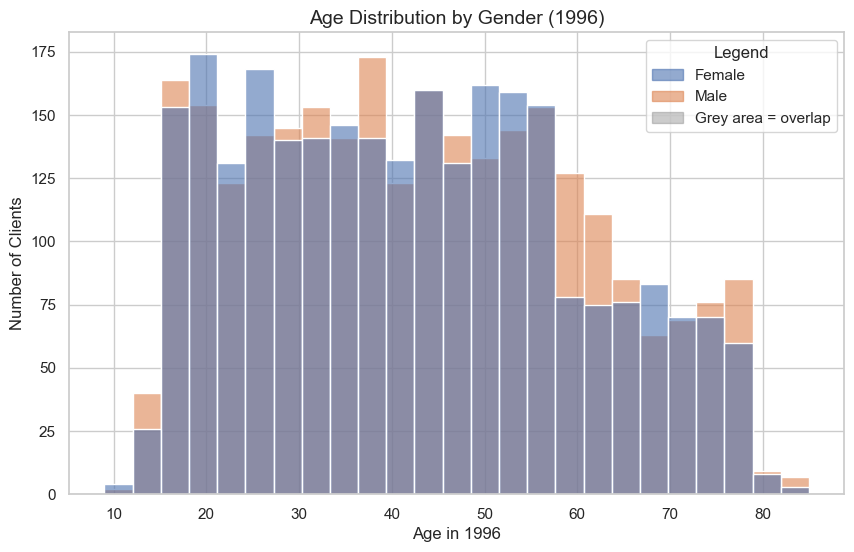

In [3508]:
#Age distribution by gender
import matplotlib.patches as mpatches

plt.figure(figsize=(10,6))

sns.histplot(
    data=client,
    x="age_1996",
    hue="gender",
    bins=25,
    kde=False,
    palette=["#4C72B0", "#DD8452"], alpha=0.6)

plt.title("Age Distribution by Gender (1996)", fontsize=14)
plt.xlabel("Age in 1996", fontsize=12)
plt.ylabel("Number of Clients", fontsize=12)

#Legend manually to insert the grey overlapping area
female_patch = mpatches.Patch(color="#4C72B0", alpha=0.6, label="Female")
male_patch   = mpatches.Patch(color="#DD8452", alpha=0.6, label="Male")
overlap_patch = mpatches.Patch(color="grey", alpha=0.4, label="Grey area = overlap")

plt.legend(handles=[female_patch, male_patch, overlap_patch], title="Legend")
save_path = r"C:\Users\Source\OneDrive - IESEG\Documents\Univerity\First semester\PYTHON PROGRAMMING FOR DATA SCIENCE 0272\PyDS_IndividualProject_Beatrice_Infurna\report\Visualizations\age_distribution_gender.png"
plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.show()


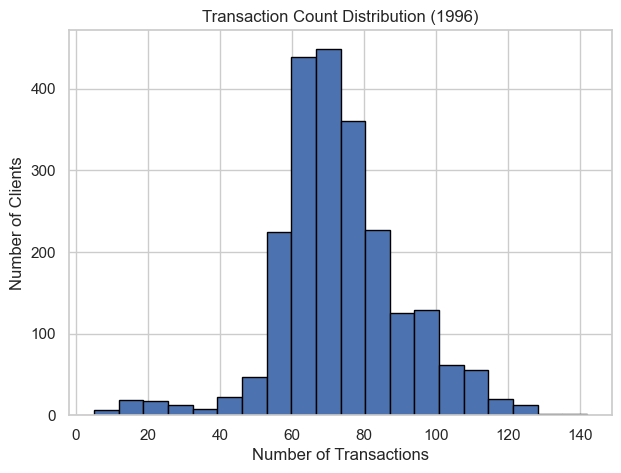

In [3509]:
#Transaction count distribution
plt.figure(figsize=(7,5))
plt.hist(basetable["txn_count_1996"], bins=20, edgecolor='black')
plt.title("Transaction Count Distribution (1996)")
plt.xlabel("Number of Transactions")
plt.ylabel("Number of Clients")
save_path = r"C:\Users\Source\OneDrive - IESEG\Documents\Univerity\First semester\PYTHON PROGRAMMING FOR DATA SCIENCE 0272\PyDS_IndividualProject_Beatrice_Infurna\report\Visualizations\txn_count_distribution.png"
plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.show()

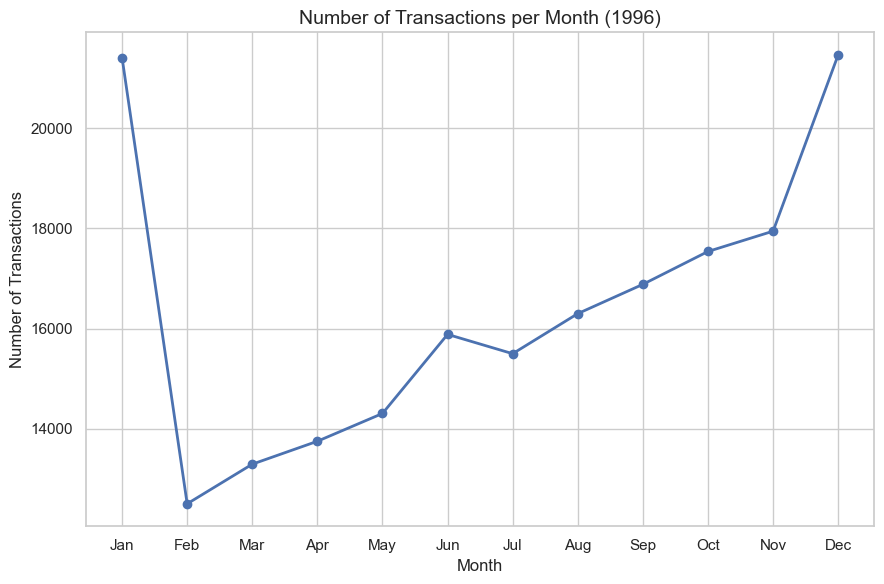

In [3510]:
#Transactions over time in 1996
import calendar

trans["date"] = pd.to_datetime(trans["date"])

trans_1996 = trans[trans["date"].dt.year == 1996].copy()
trans_1996["month"] = trans_1996["date"].dt.month
txn_per_month = trans_1996.groupby("month").size()
month_names = [calendar.month_abbr[m] for m in txn_per_month.index]

plt.figure(figsize=(9,6))

plt.plot(
    month_names,
    txn_per_month.values,
    marker="o",
    linewidth=2,)

plt.title("Number of Transactions per Month (1996)", fontsize=14)
plt.xlabel("Month", fontsize=12)
plt.ylabel("Number of Transactions", fontsize=12)

# save
save_path = r"C:\Users\Source\OneDrive - IESEG\Documents\Univerity\First semester\PYTHON PROGRAMMING FOR DATA SCIENCE 0272\PyDS_IndividualProject_Beatrice_Infurna\report\Visualizations\transactions_over_time_1996.png"
plt.savefig(save_path, dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()


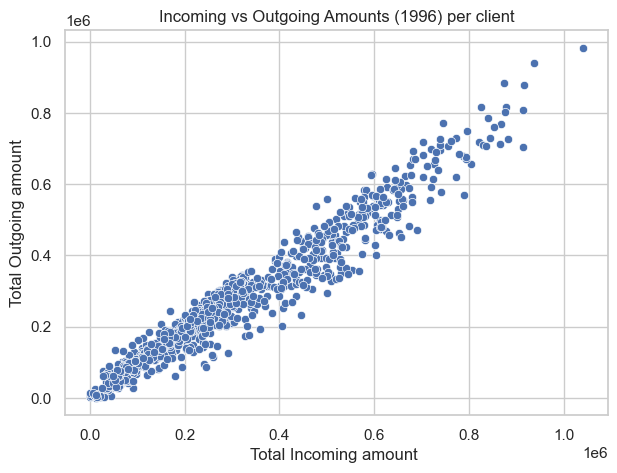

In [3511]:
#Incoming vs Outgoing totals
plt.figure(figsize=(7,5))
sns.scatterplot(
    data=basetable,
    x="incoming_total_1996",
    y="outgoing_total_1996")
plt.title("Incoming vs Outgoing Amounts (1996) per client")
plt.xlabel("Total Incoming amount ")
plt.ylabel("Total Outgoing amount")
save_path = r"C:\Users\Source\OneDrive - IESEG\Documents\Univerity\First semester\PYTHON PROGRAMMING FOR DATA SCIENCE 0272\PyDS_IndividualProject_Beatrice_Infurna\report\Visualizations\incoming_vs_outgoing.png"
plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.show()


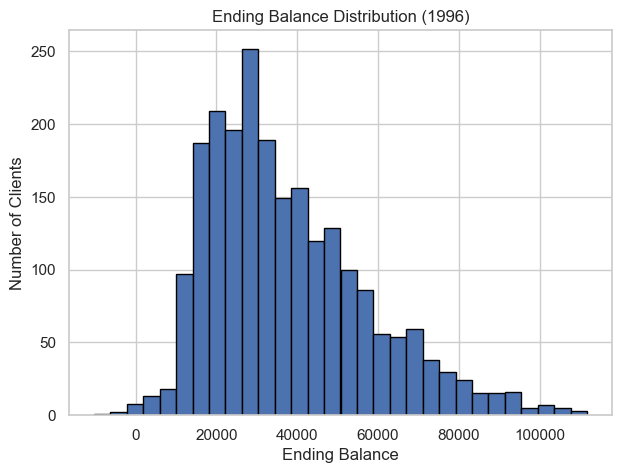

In [3512]:
#Ending Balance Distribution
plt.figure(figsize=(7,5))
plt.hist(basetable["ending_balance_1996"], bins=30, edgecolor='black')
plt.title("Ending Balance Distribution (1996)")
plt.xlabel("Ending Balance")
plt.ylabel("Number of Clients")
save_path = r"C:\Users\Source\OneDrive - IESEG\Documents\Univerity\First semester\PYTHON PROGRAMMING FOR DATA SCIENCE 0272\PyDS_IndividualProject_Beatrice_Infurna\report\Visualizations\ending_balance_distribution.png"
plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.show()


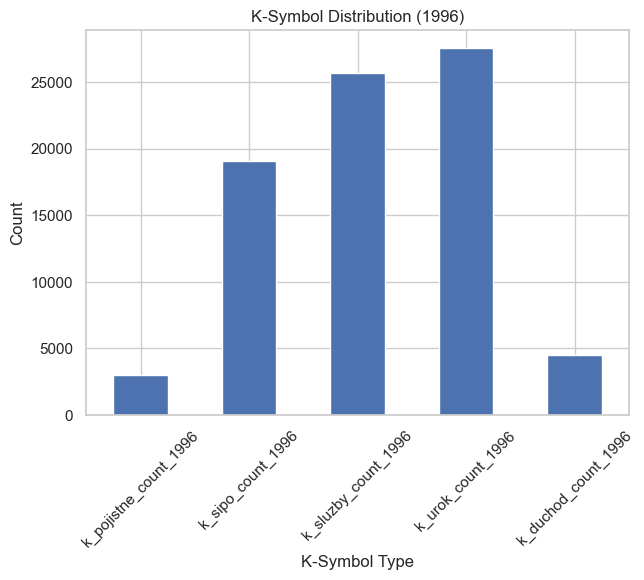

In [3513]:
#K-symbol type counts
k_cols = [
    "k_pojistne_count_1996",
    "k_sipo_count_1996",
    "k_sluzby_count_1996",
    "k_urok_count_1996",
    "k_duchod_count_1996"]

basetable[k_cols].sum().plot(kind='bar', figsize=(7,5))
plt.title("K-Symbol Distribution (1996)")
plt.xlabel("K-Symbol Type")
plt.ylabel("Count")
plt.xticks(rotation=45)

save_path = r"C:\Users\Source\OneDrive - IESEG\Documents\Univerity\First semester\PYTHON PROGRAMMING FOR DATA SCIENCE 0272\PyDS_IndividualProject_Beatrice_Infurna\report\Visualizations\k_symbol_distribution.png"
plt.savefig(save_path, dpi=300, bbox_inches='tight')

plt.show()


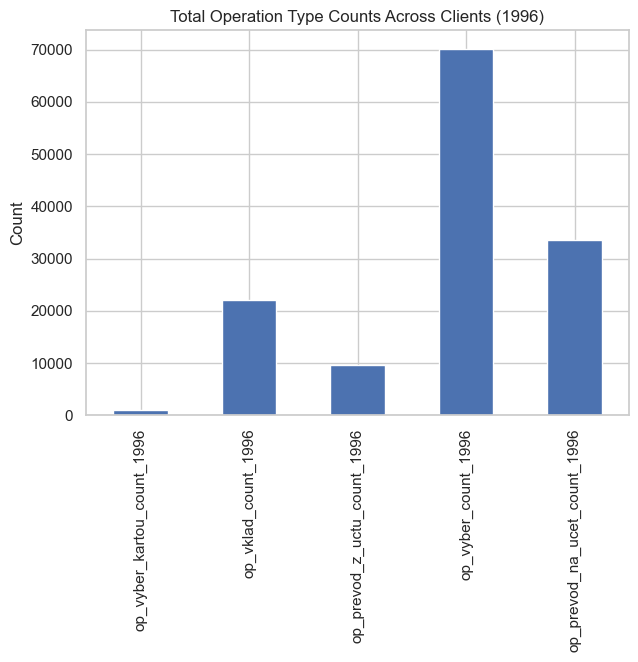

In [3514]:
#Operation type counts
op_cols = [
    "op_vyber_kartou_count_1996",
    "op_vklad_count_1996",
    "op_prevod_z_uctu_count_1996",
    "op_vyber_count_1996",
    "op_prevod_na_ucet_count_1996"]

basetable[op_cols].sum().plot(kind='bar', figsize=(7,5))
plt.title("Total Operation Type Counts Across Clients (1996)")
plt.ylabel("Count")
plt.show()


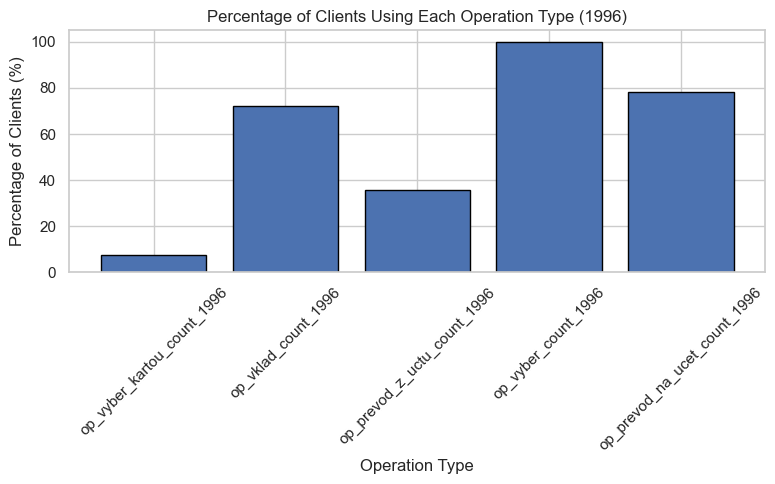

In [3515]:
#Operation type usage percentage
op_cols = [
    "op_vyber_kartou_count_1996", 
    "op_vklad_count_1996", 
    "op_prevod_z_uctu_count_1996",
    "op_vyber_count_1996", 
    "op_prevod_na_ucet_count_1996"]

op_usage = (basetable[op_cols] > 0).mean() * 100

plt.figure(figsize=(8,5))
plt.bar(op_usage.index, op_usage.values, edgecolor='black')
plt.title("Percentage of Clients Using Each Operation Type (1996)")
plt.xlabel("Operation Type")
plt.ylabel("Percentage of Clients (%)")
plt.xticks(rotation=45)

save_path = r"C:\Users\Source\OneDrive - IESEG\Documents\Univerity\First semester\PYTHON PROGRAMMING FOR DATA SCIENCE 0272\PyDS_IndividualProject_Beatrice_Infurna\report\Visualizations\operation_type_percentage.png"
plt.savefig(save_path, dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()


### Dependent Variables

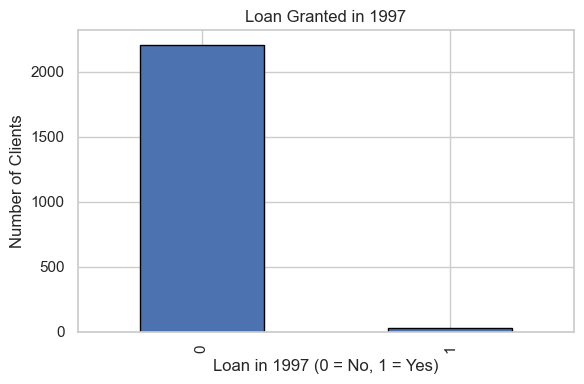

In [3516]:
#Loan(s) granted in 1997
plt.figure(figsize=(6,4))
basetable["dv_loan_1997"].value_counts().plot(kind='bar', edgecolor='black')

plt.title("Loan Granted in 1997")
plt.xlabel("Loan in 1997 (0 = No, 1 = Yes)")
plt.ylabel("Number of Clients")

save_path = r"C:\Users\Source\OneDrive - IESEG\Documents\Univerity\First semester\PYTHON PROGRAMMING FOR DATA SCIENCE 0272\PyDS_IndividualProject_Beatrice_Infurna\report\Visualizations\dv_loan_1997_distribution.png"
plt.savefig(save_path, dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()



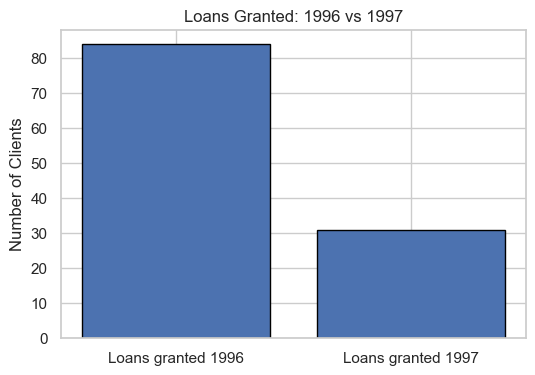

In [3517]:

# Counts of loans granted in 1996 vs 1997 (DV)
loan_counts = {
    "Loans granted 1996": basetable["loan_granted_1996"].sum(),
    "Loans granted 1997": basetable["dv_loan_1997"].sum()}

plt.figure(figsize=(6, 4))
plt.bar(loan_counts.keys(), loan_counts.values(), edgecolor="black")
plt.title("Loans Granted: 1996 vs 1997")
plt.ylabel("Number of Clients")

save_path = r"C:\Users\Source\OneDrive - IESEG\Documents\Univerity\First semester\PYTHON PROGRAMMING FOR DATA SCIENCE 0272\PyDS_IndividualProject_Beatrice_Infurna\report\Visualizations\loan_granted_96_97.png"
plt.savefig(save_path, dpi=300, bbox_inches="tight")

plt.show()


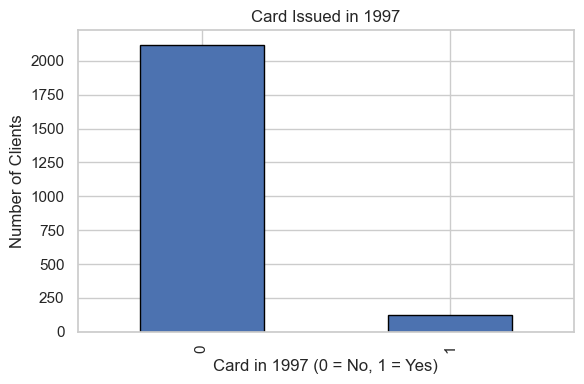

In [3518]:
#Cards issued in 1997
plt.figure(figsize=(6,4))
basetable["dv_card_1997"].value_counts().plot(kind='bar', edgecolor='black')

plt.title("Card Issued in 1997")
plt.xlabel("Card in 1997 (0 = No, 1 = Yes)")
plt.ylabel("Number of Clients")

save_path = r"C:\Users\Source\OneDrive - IESEG\Documents\Univerity\First semester\PYTHON PROGRAMMING FOR DATA SCIENCE 0272\PyDS_IndividualProject_Beatrice_Infurna\report\Visualizations\dv_card_1997_distribution.png"
plt.savefig(save_path, dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()



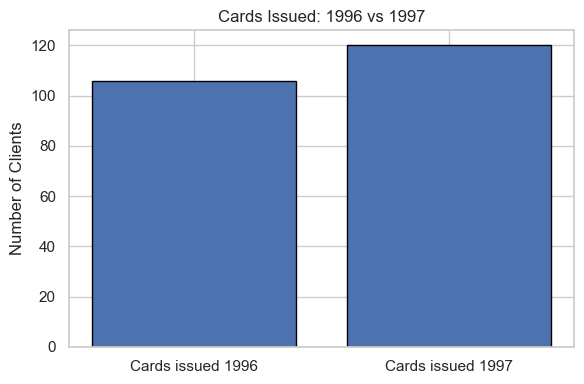

In [3519]:
#comparison of cards issued in 1996 vs 1997
counts_cards = {
    "Cards issued 1996": basetable["card_issued_1996"].sum(),
    "Cards issued 1997": basetable["dv_card_1997"].sum()}

plt.figure(figsize=(6,4))
plt.bar(counts_cards.keys(), counts_cards.values(), edgecolor='black')
plt.title("Cards Issued: 1996 vs 1997")
plt.ylabel("Number of Clients")

save_path = r"C:\Users\Source\OneDrive - IESEG\Documents\Univerity\First semester\PYTHON PROGRAMMING FOR DATA SCIENCE 0272\PyDS_IndividualProject_Beatrice_Infurna\report\Visualizations\card_issued_96_97.png"
plt.savefig(save_path, dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()


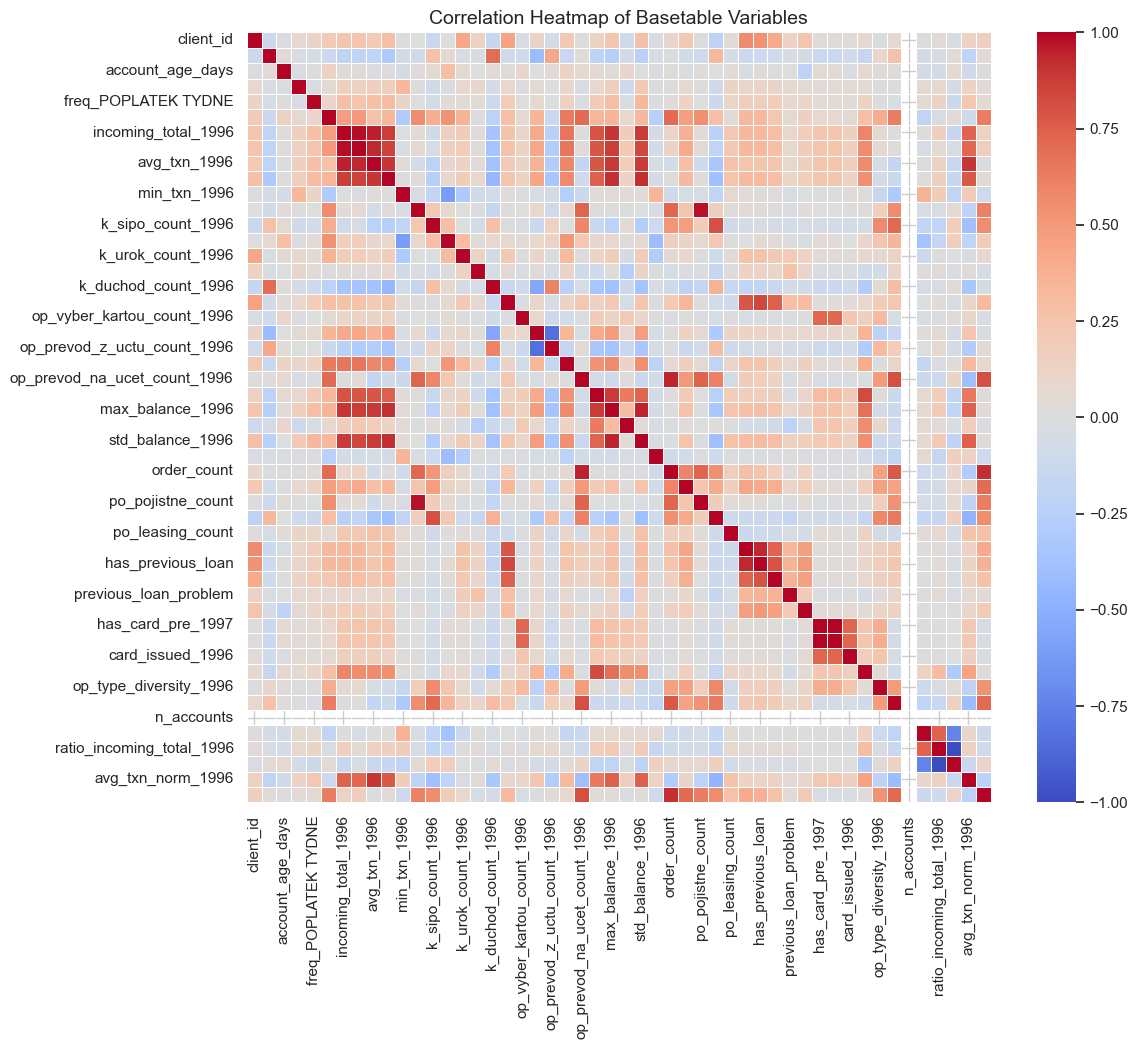

In [3520]:
#Correlation heathmap
numeric_cols = basetable.select_dtypes(include=["int64", "float64"])
corr_matrix = numeric_cols.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(
    corr_matrix, 
    cmap="coolwarm", 
    annot=False,  
    linewidths=0.5)

plt.title("Correlation Heatmap of Basetable Variables", fontsize=14)

save_path = r"C:\Users\Source\OneDrive - IESEG\Documents\Univerity\First semester\PYTHON PROGRAMMING FOR DATA SCIENCE 0272\PyDS_IndividualProject_Beatrice_Infurna\report\Visualizations\correlation_heatmap.png"
plt.savefig(save_path, dpi=300, bbox_inches='tight')

plt.show()

